# pySCENIC protocol

(Tutorial applied to our VEO-IBD Data)

In [75]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import pyscenic

In [4]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/Users/samibening/Projects/Bachelor/"
os.chdir( wdir )

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "SCENICfiles/data_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "data/output/adata.h5ad"

# path to pyscenic output
f_pyscenic_output = "SCENICfiles/pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'SCENICfiles/scenic_integrated-output.loom'

In [5]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
MulticoreTSNE               NA
PIL                         10.2.0
anyio                       NA
appnope                     0.1.4
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
cloudpickle                 3.0.0
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
cytoolz                     0.12.3
dask                        2024.1.1
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
exceptiongroup              1.2.0
executing                   2.0.1
fastjsonschema              NA
fqdn                        NA
h5py                        3.10.0
idna                        3

In [4]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = -1

## Expression data import
There are several ways to import expression data. For simplicity we focus on getting the data into a Scanpy anndata object or a loom file.  Scanpy provides functions for reading in a wide variety of formats (described [here](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/index.html#reading)).

In [6]:
adata = sc.read_h5ad(os.path.join(os.getcwd(), f_anndata_path))
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    obsp: 'connectivitie

### write to an unfiltered loom file

Here, we use the loompy functions directly

In [8]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

## Initial/basic filtering

In [ ]:
# done beforehand, read in adata file is already preprocessed and filtered

Output the basic filtered expression matrix to a loom file.  

This can also be used in the command-line pySCENIC steps, for example, or as an input to the Nextflow pipeline.

In [6]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.layers["raw"].transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.layers['raw'].transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.layers['raw'].transpose(), row_attrs, col_attrs)

## Further pre-processing of expression data

In [13]:
# also done beforehand
adata.layers['raw']

<5397x16719 sparse matrix of type '<class 'numpy.float32'>'
	with 12351518 stored elements in Compressed Sparse Row format>

## SCENIC steps

### STEP 1: Gene regulatory network inference, and generation of co-expression modules
#### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier.
_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

In [6]:
# transcription factors list
f_tfs = os.path.join("SCENICfiles/allTFs_hg38.txt") # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )
f_tfs

'SCENICfiles/allTFs_hg38.txt'

In [7]:
f_loom_path_scenic

'SCENICfiles/data_filtered_scenic.loom'

In [ ]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o SCENICfiles/adj.csv --num_workers 20

^C


preparing dask client
parsing input
creating dask graph
7 partitions
computing dask graph
not shutting down client, client was created externally
finished


C:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\loompy\bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
C:\Users\saman\anaconda3\envs\gobi_env\lib\site-packages\loompy\bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
C:\Users\saman\anaconda3\e

read in the adjacencies matrix:

In [8]:
adjacencies = pd.read_csv(os.path.join("SCENICfiles/adj.csv"), index_col=False)
adjacencies.head()

,TF,target,importance
0,RPS4X,RPLP1,13.466235
1,ERF,NRTN,12.305384
2,ZBTB37,GAS6-AS1,11.857625
3,RPL6,RPSA,10.889219
4,RUNX2,PARD6G-AS1,10.886650


### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

locations for ranking databases, and motif annotations:

In [42]:
# ranking databases
f_db_glob = "https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/" # not the file directory, have to download from here(2022 SCENIC+ version)
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "https://resources.aertslab.org/cistarget/motif2tf/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tb" # not file directory, have to download from here 

Here, we use the `--mask_dropouts` option, which affects how the correlation between TF and target genes is calculated during module creation. It is important to note that prior to pySCENIC v0.9.18, the default behavior was to mask dropouts, while in v0.9.18 and later, the correlation is performed using the entire set of cells (including those with zero expression). When using the `modules_from_adjacencies` function directly in python instead of via the command line, the `rho_mask_dropouts` option can be used to control this.

In [ ]:
!pyscenic ctx adj.tsv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output SCENICfiles/reg.csv \
    --mask_dropouts \
    --num_workers 20

### STEP 4: Cellular enrichment (aka AUCell) from CLI

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC.
The following histogram gives an idea of the distribution and allows selection of an appropriate threshold.
In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses).
See [the relevant section in the R tutorial](https://bioconductor.org/packages/devel/bioc/vignettes/AUCell/inst/doc/AUCell.html#build-gene-expression-rankings-for-each-cell) for more information.

By using the default setting for `--auc_threshold` of `0.05`, we see that **1192** genes are selected for the rankings based on the plot below.

In [9]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
nGenesDetectedPerCell = pd.DataFrame(nGenesDetectedPerCell)
percentiles = nGenesDetectedPerCell.quantile([.01, .05, .10, .50, 1])
percentiles.index.values

array([0.01, 0.05, 0.1 , 0.5 , 1.  ])

/var/folders/q4/ywlg60x9791g_364np64pv6m0000gn/T/ipykernel_9328/2525030026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')


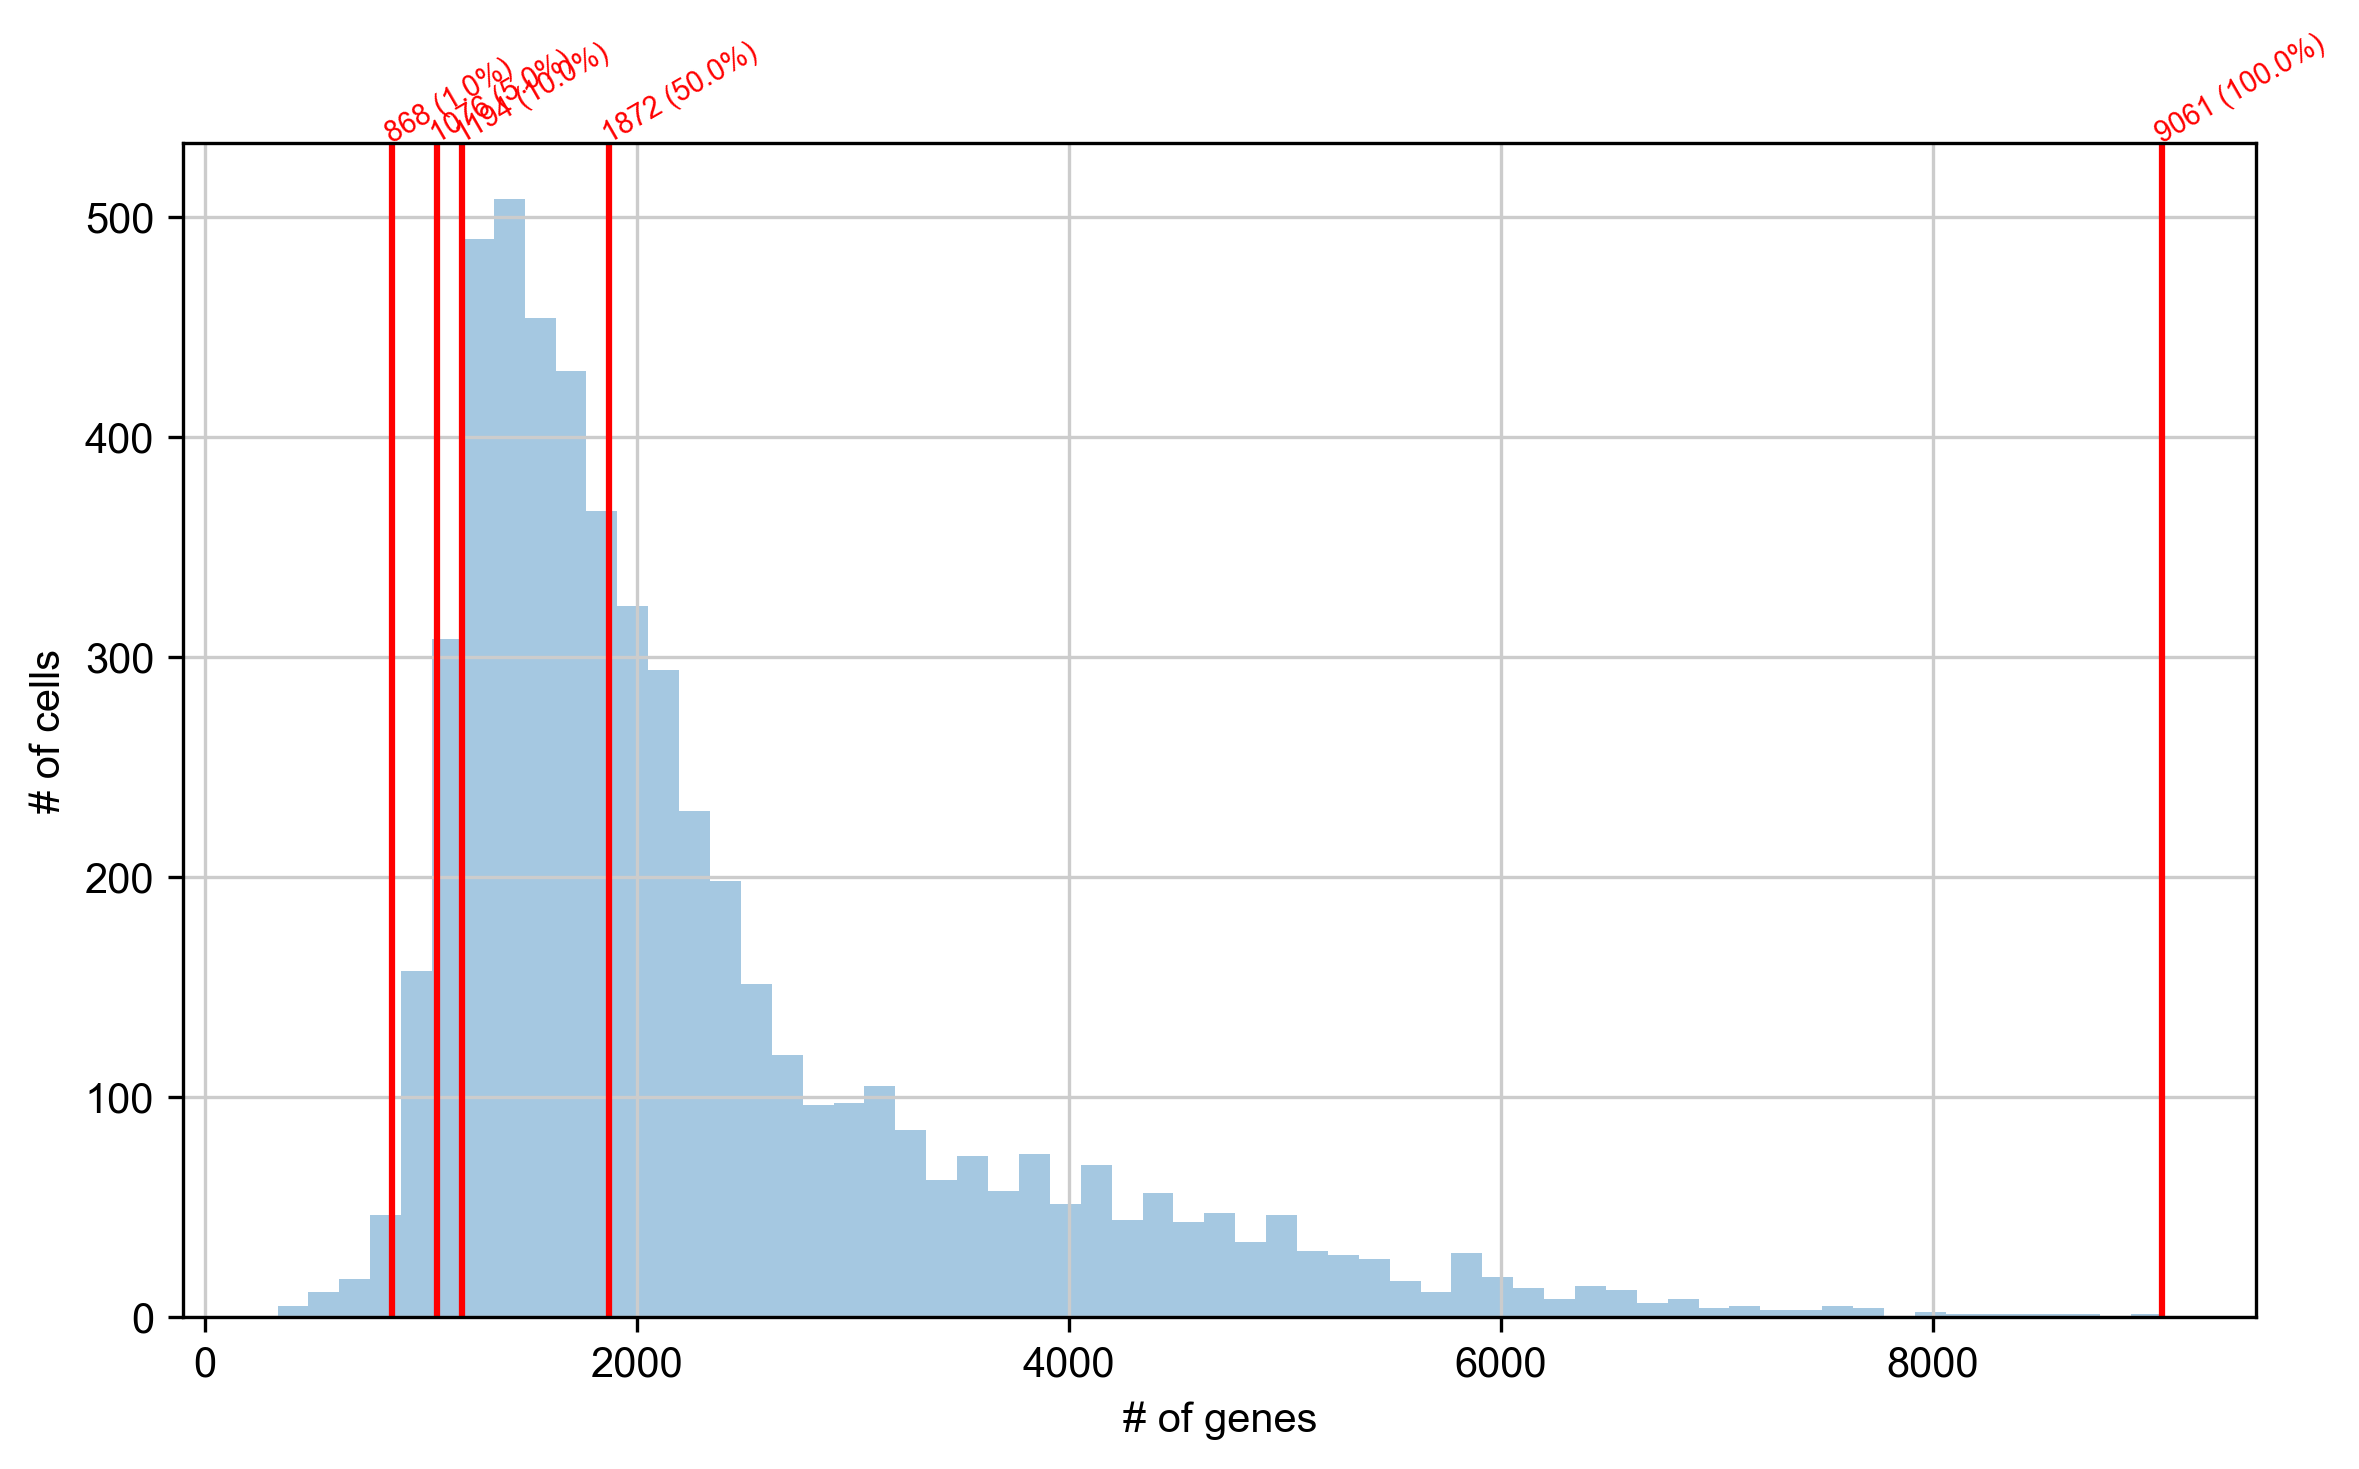

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,j in percentiles.iterrows():
    fig.gca().axvline(x=j.values[0], ymin=0,ymax=1, color='red')
    ax.text(x=j.values[0], y=ax.get_ylim()[1], s=f'{int(j.values[0])} ({i*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [27]:
f_loom_path_scenic

'SCENICfiles/data_filtered_scenic.loom'

In [7]:
!pyscenic aucell SCENICfiles/data_filtered_scenic.loom SCENICfiles/reg.csv --output SCENICfiles/pyscenic_output.loom --num_workers 20

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2024-02-07 19:29:50,943 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-02-07 19:29:52,063 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2024-02-07 19:29:53,026 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_a

### Visualization of SCENIC's AUC matrix

First, load the relevant data from the loom we just created

In [11]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

['']

In [13]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "SCENICfiles/scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "SCENICfiles/scenic_tsne.txt", sep='\t')

/Users/samibening/micromamba/envs/pyscenic2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Integrate the output

Here, we combine the results from SCENIC and the Scanpy analysis into a SCope-compatible loom file

In [14]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'SCENICfiles/scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'SCENICfiles/scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [68]:
auc_mtx

,ARID3A(+),ARNT(+),ATF1(+),ATF3(+),ATF4(+),ATOH1(+),BACH1(+),BACH2(+),BCL11A(+),BCL11B(+),...,ZNF773(+),ZNF783(+),ZNF786(+),ZNF808(+),ZNF814(+),ZNF846(+),ZNF91(+),ZSCAN26(+),ZSCAN5A(+),ZXDC(+)
CID005217-1-AACAGGGGTGAATGAT,0.009117,0.016796,0.026651,0.058431,0.043990,0.0,0.025285,0.036018,0.000000,0.000000,...,0.0,0.0,0.000000,0.039155,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CID005217-1-AACCAACGTCATCGCG,0.002897,0.000000,0.019617,0.098680,0.049890,0.0,0.025903,0.039806,0.018953,0.000000,...,0.0,0.0,0.011107,0.000000,0.000000,0.028243,0.000000,0.000000,0.000000,0.0
CID005217-1-AACCACAAGAGGCCAT,0.014487,0.000000,0.000000,0.069790,0.050283,0.0,0.047022,0.102671,0.179851,0.047761,...,0.0,0.0,0.004016,0.005130,0.000000,0.010699,0.000000,0.006699,0.188995,0.0
CID005217-1-AACCTTTAGCTCGGCT,0.005130,0.000000,0.000000,0.054371,0.034237,0.0,0.019964,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.004147,0.000000,0.000797,0.000000,0.000000,0.000000,0.0
CID005217-1-AACGAAATCCAAAGGG,0.009237,0.000000,0.035933,0.040868,0.046203,0.0,0.033080,0.028309,0.022249,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.001728,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CID008474-1-TTTGATCGTGCCGGTT,0.000465,0.000000,0.022392,0.059805,0.054028,0.0,0.061294,0.074561,0.052073,0.022044,...,0.0,0.0,0.000000,0.006539,0.000000,0.025784,0.004884,0.000000,0.000000,0.0
CID008474-1-TTTGGAGGTCGATGCC,0.000000,0.000000,0.009522,0.046348,0.040023,0.0,0.004620,0.000000,0.000638,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CID008474-1-TTTGGTTCATTCTCCG,0.000000,0.000000,0.000000,0.050349,0.035336,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000106,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
CID008474-1-TTTGGTTTCCGAACGC,0.000000,0.000000,0.000000,0.044036,0.031955,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.016879,0.023791,0.000000,0.000000,0.000000,0.0


In [66]:
reg_mtx = pd.DataFrame( lf.ra.Regulons, index=lf.ra.Gene)
reg_mtx

,ARID3A_(+),ARNT_(+),ATF1_(+),ATF3_(+),ATF4_(+),ATOH1_(+),BACH1_(+),BACH2_(+),BCL11A_(+),BCL11B_(+),...,ZNF773_(+),ZNF783_(+),ZNF786_(+),ZNF808_(+),ZNF814_(+),ZNF846_(+),ZNF91_(+),ZSCAN26_(+),ZSCAN5A_(+),ZXDC_(+)
AL669831.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LINC00115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM41C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOC2L,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC004556.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC233755.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC233755.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

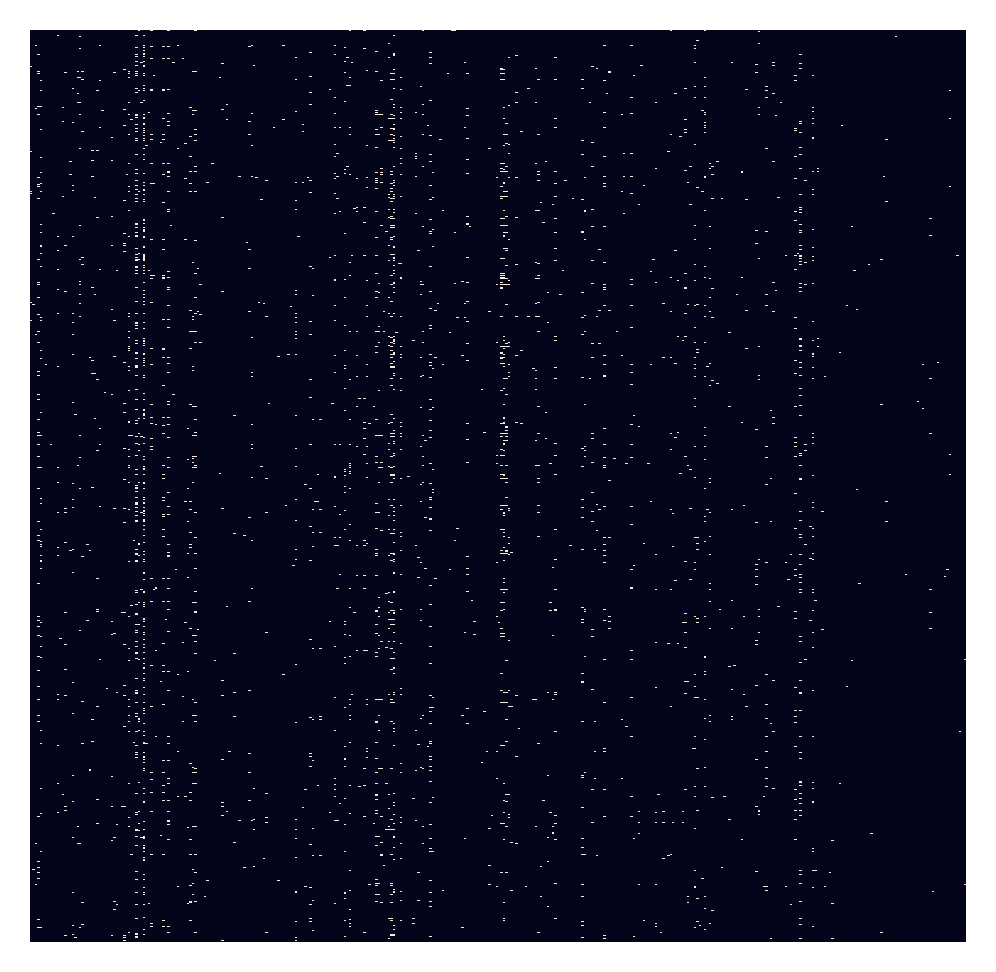

In [79]:
sns.heatmap(reg_mtx, xticklabels=False, yticklabels=False, cbar=False, rasterized=False)

Fix regulon objects to display properly in SCope:

In [15]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

Concatenate embeddings (tSNE, UMAP, etc.)

In [16]:
# tSNE

sc.tl.tsne( adata, use_rep='X_pca', n_jobs=20, use_fast_tsne=True)
adata

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)


/Users/samibening/micromamba/envs/pyscenic2/lib/python3.10/site-packages/scanpy/tools/_tsne.py:114: FutureWarning: Argument `use_fast_tsne` is deprecated, and support for MulticoreTSNE will be dropped in a future version of scanpy.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:07)


AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap', 'tsne'
    obsm: 'X_pca', 'X_scVI', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    ob

In [17]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

Metadata:

In [18]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy_leiden_res0_6",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Leiden_clusters_Scanpy",
        "values": list(set( adata.obs['leiden_res0_6'].astype(str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['leiden_res0_6']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['leiden_res0_6'].values.astype(np.int64)

Assemble loom file row and column attributes

In [19]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [20]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "Total_counts(nUMI)": np.array(adata.obs['total_counts'].values),
    "nGene": np.array(adata.obs['n_genes_by_counts'].values),
    "Leiden_clusters_Scanpy": np.array( adata.obs['leiden_res0_6'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Pct_counts_mt": np.array(adata.obs['pct_counts_mt'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    #"Embeddings_X": dfToNamedMatrix(Embeddings_X),
    #"Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    #"RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['leiden_res0_6'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "subset_scope_tester",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [21]:
f_final_loom2 = 'SCENICfiles/scenic_scanpy_integrated-output.loom'

Create a new loom file, copying the expression matrix from the open loom connection:

In [22]:
lp.create(
    filename = f_final_loom2 ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

This loom file can now be imported into [SCope](http://scope.aertslab.org/).

In [29]:
ps_adata = sc.read_loom(f_final_loom, validate = False)
ps_adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'ClusterID', 'Clusterings', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'Louvain_clusters_Scanpy', 'Pct_counts_mt', 'RegulonsAUC', 'Total_counts(nUMI)', 'nGene'
    var: 'Regulons'

In [44]:
ps_adata.obs['Clusterings'][0]

/var/folders/q4/ywlg60x9791g_364np64pv6m0000gn/T/ipykernel_10635/3186293688.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ps_adata.obs['Clusterings'][0]


(6,)